In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter("ignore")
import datetime

## Загрузка данных

Данные загружены с сайта https://www.cmegroup.com на 24 августа 2022 г.

In [14]:
path = r'/Users/nikitasencilo/PycharmProjects/gazp_exp_tst/ogk-web-prices/'

In [15]:
df = pd.read_csv(path + 'dutch_futures.csv',sep=';')
df=df[['MONTH','CHANGE','SETTLE']]
df['SPOT'] = df['SETTLE']*0.99
start=pd.to_datetime(df.iloc[0]['MONTH'],format='%b %y')
end=pd.to_datetime(df.iloc[-1]['MONTH'],format='%b %y')
df['DT']=pd.date_range(start=datetime.datetime(2022,9,1),end=datetime.datetime(2032,1,1),freq='1M')

In [16]:
df_train = df[:36]
df_test=df[36:]

Для построения функциональной зависимости построим график цен фьючерсов на 36 месяцев вперед.

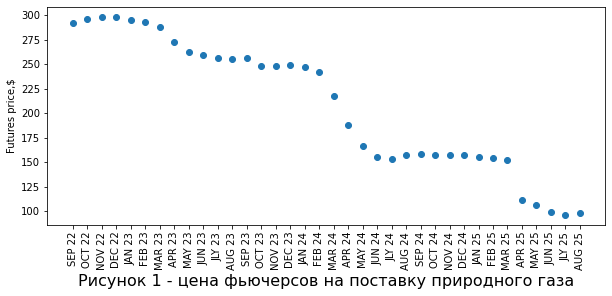

In [20]:
plt.figure(figsize=(10,4))
plt.plot(df_train['MONTH'],df_train['SETTLE'],'o')
plt.ylabel('Futures price,$')
plt.xticks(rotation=90)
plt.xlabel("Рисунок 1 - цена фьючерсов на поставку природного газа", fontsize=16)
plt.show()

### Вывод 
При анализе графика на рисунке 1, можно сделать вывод, что цена фьючерсов на поставку газа снижается, что соответствует рынку в состоянии контанго (рис.2).
![title](kib.png)
<h4 align='center'>Рисунок 2 - контанго и бэквордация</h4>

Отбор газа из европейских хранилищ, а также сокращение поставок из России спровоцировали   снижение   мировых   запасов   до минимальных отметок. Наконец, пик спроса на электроэнергию на фоне прогнозируемой холодной зимы и жаркого лета привел к дальнейшему сокращению запасов газа в хранилищах ЕС и Азии, что повлекло за собой рост цен на газ на спотовом рынке.
Следовательно, при высоком спросе на газ с приближением отопительного сезона фьючерсы превышают спотовую цену на газ. Также с учетом издержек для хранения газа при покупке и волатильности цен контанго является типичным для рынка фьючерсов на газ.


## Восстановление кривой

В первую очередь, разделим данные на тренировочную (первые 36 месяцев согласно заданию) и тестовую выборки.

In [23]:
y_train = df_train['SETTLE'].values
x_train = df_train.index

y_test = df_test['SETTLE'].values
x_test = df_test.index

Для кривой используем экспоненциальную функцию. Аргументом экспоненты будет отрицательная квадратичная функция, так как график контанго является нелинейным.

In [29]:
#  экспонента 
def func(x,a,b,c):
    return a * np.exp(-b * x**2) + c
# подбор оптимальных параметров
popt, pcov = curve_fit(func, x_train, y_train,
                       method='lm',
                       maxfev=6000)
# расчет ошибки
mse = np.sqrt(mean_squared_error(y_train,func(x_train, *popt)))
mse_forecast = np.sqrt(mean_squared_error(y_test,func(x_test, *popt)))

Оптимальнаые параметры a = 235.95 b = 0.0014 c = 60.51


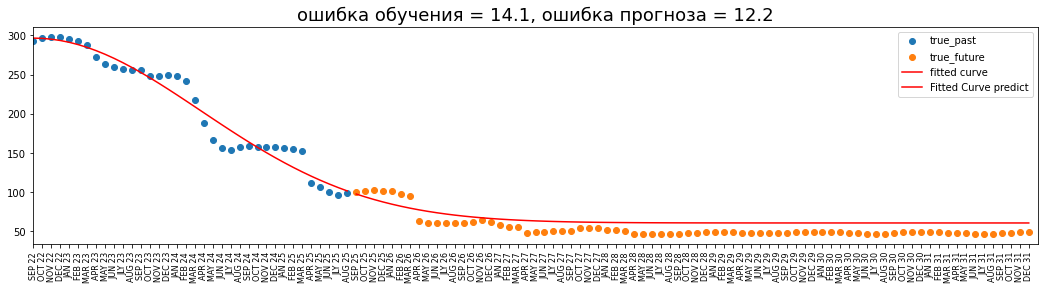

In [37]:
fig,ax=plt.subplots(1,1,figsize=(18,4))
print("Оптимальнаые параметры a = {:.2f} b = {:.4f} c = {:.2f}".format(popt[0],popt[1],popt[2]))
plt.title('ошибка обучения = {:.1f}, ошибка прогноза = {:.1f}'.format(mse,mse_forecast),fontsize=18)
ax.scatter(df_train['MONTH'],df_train['SETTLE'],label='true_past')
ax.scatter(df_test['MONTH'],df_test['SETTLE'],label='true_future')

ax.plot(x_train, func(x_train, *popt), 'r-', label='fitted curve')
ax.plot(x_test, func(x_test, *popt), 'r-', label="Fitted Curve predict")

plt.xticks(rotation=90,fontsize=8)
plt.xlim(0,len(df))
plt.legend()
plt.show()

# Вывод
В результате получена восстновленная кривая фьючерсов с прогнозов на будущий период.
Из анализа графика можно заключить, что при увеличении срока прогноза цена фьючерса становится постоянной и приближается к спотовой цене на газ.